# Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.layers import Conv1D, Flatten, Dense
from xgboost import XGBRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

In [3]:
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rajshekar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Importing Dataset

### Loading Previous Datasets

In [6]:
df_all_stock_data = pd.read_csv('combined_stock_data_cleaned.csv')
df_reddit = pd.read_csv('reddit_stockmarket_raw.csv')
df_financials = pd.read_csv('financial_data_raw.csv')

### Cleaning the Datasets

### Reddit Dataset

In [9]:
# Remove duplicate Reddit posts based on 'Post URL' to keep only the first occurrence
df_reddit.drop_duplicates(subset=['Post URL'], keep='first', inplace=True)

# Convert 'Date' column to datetime format for easier time-based operations
df_reddit['Date'] = pd.to_datetime(df_reddit['Date'])

# Initialize tools for text preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean and lemmatize the text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    words = word_tokenize(text)  # Tokenize the text
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing to Reddit post titles
df_reddit['Processed_Title'] = df_reddit['Title'].apply(preprocess_text)

# Function to perform sentiment analysis using VADER on processed titles
def sentiment_analysis_on_processed_title(df):
    analyzer = SentimentIntensityAnalyzer()

    # Extract positive and negative sentiment scores
    def get_sentiment(title):
        sentiment = analyzer.polarity_scores(title)
        return sentiment['pos'], sentiment['neg']

    # Apply sentiment scoring to each processed title
    df[['Sentiment_Positive', 'Sentiment_Negative']] = df['Processed_Title'].apply(lambda x: pd.Series(get_sentiment(x)))

    return df

# Perform sentiment analysis
df_reddit = sentiment_analysis_on_processed_title(df_reddit)

# Export the cleaned and enriched dataset to CSV
df_reddit.to_csv('reddit_stockmarket_cleaned.csv', index=False)


### Cleaning Financial Metrics and Company Income

In [11]:
# Define a function to preprocess financial data by handling missing values, type conversion, filtering, and normalization.
df_financials = df_financials.dropna(axis=1, how='all')
def preprocess_financial_data(df):
    # Fill missing values in financial columns with their respective column means.
    df['P/E Ratio'] = df['P/E Ratio'].fillna(df['P/E Ratio'].mean())
    df['EPS'] = df['EPS'].fillna(df['EPS'].mean())
    df['Market Cap'] = df['Market Cap'].fillna(df['Market Cap'].mean())
    df['Dividend Yield'] = df['Dividend Yield'].fillna(df['Dividend Yield'].mean())

    # Convert the columns to numeric type, coercing any invalid entries to NaN.
    df['P/E Ratio'] = pd.to_numeric(df['P/E Ratio'], errors='coerce')
    df['EPS'] = pd.to_numeric(df['EPS'], errors='coerce')
    df['Market Cap'] = pd.to_numeric(df['Market Cap'], errors='coerce')
    df['Dividend Yield'] = pd.to_numeric(df['Dividend Yield'], errors='coerce')

    # Filter the DataFrame to include only records with reasonable P/E ratios (between 0 and 100).
    df = df[(df['P/E Ratio'] > 0) & (df['P/E Ratio'] < 100)]

    # Normalize selected financial columns using Min-Max scaling to bring values into the 0–1 range.
    scaler = MinMaxScaler()
    df[['P/E Ratio', 'EPS', 'Market Cap']] = scaler.fit_transform(df[['P/E Ratio', 'EPS', 'Market Cap']])

    # Return the cleaned and normalized DataFrame.
    return df

# Apply the preprocessing function to the financials DataFrame.
df_financials_cleaned = preprocess_financial_data(df_financials)


# Save the cleaned financial data to a new CSV file.
df_financials.to_csv('financial_data_cleaned.csv', index=False)

/var/folders/52/9ddv2mw95qd45cytzrl7jmfm0000gn/T/ipykernel_37287/2572830614.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['P/E Ratio', 'EPS', 'Market Cap']] = scaler.fit_transform(df[['P/E Ratio', 'EPS', 'Market Cap']])


### Combining the Datasets

In [13]:
# Standardize column names to ensure consistency across all datasets.
df_all_stock_data.rename(columns={'datetime': 'Date'}, inplace=True)  
df_financials.rename(columns={'Date': 'Date'}, inplace=True)  
df_reddit.rename(columns={'Date': 'Date'}, inplace=True)

In [14]:
# Convert the 'Date' column in all datasets to datetime format.
df_all_stock_data['Date'] = pd.to_datetime(df_all_stock_data['Date'])
df_financials['Date'] = pd.to_datetime(df_financials['Date'])
df_reddit['Date'] = pd.to_datetime(df_reddit['Date'])

# Extract only the date component (drop time) to ensure accurate merging.
df_all_stock_data['Date'] = df_all_stock_data['Date'].dt.date
df_financials['Date'] = df_financials['Date'].dt.date
df_reddit['Date'] = df_reddit['Date'].dt.date

# Merge stock price data with financial data on 'Date' and 'Ticker' using inner join to retain only matching records.
df_combined = pd.merge(df_all_stock_data, df_financials, on=['Date', 'Ticker'], how='inner')

# Merge the resulting DataFrame with Reddit sentiment data on 'Date' and 'Ticker' to create the final dataset.
df_final = pd.merge(df_combined, df_reddit, on=['Date', 'Ticker'], how='inner')

In [15]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159 entries, 0 to 1158
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   1159 non-null   object 
 1   open                   1159 non-null   float64
 2   high                   1159 non-null   float64
 3   low                    1159 non-null   float64
 4   close                  1159 non-null   float64
 5   volume                 1159 non-null   int64  
 6   Ticker                 1159 non-null   object 
 7   Stock Price (Closing)  1159 non-null   float64
 8   P/E Ratio              1159 non-null   float64
 9   EPS                    1159 non-null   float64
 10  Market Cap             1159 non-null   int64  
 11  Dividend Yield         1159 non-null   float64
 12  Company Name           1159 non-null   object 
 13  Net Income             1159 non-null   int64  
 14  Gross Profit           1159 non-null   int64  
 15  Tota

### Saving the Dataset

In [17]:
df_final.to_csv('merged_dataset.csv', index=False)

### Loading Dataset

In [19]:
df=pd.read_csv('merged_dataset.csv')

# EDA

In [21]:
df.head()

,Date,open,high,low,close,volume,Ticker,Stock Price (Closing),P/E Ratio,EPS,...,Net Income,Gross Profit,Total Revenue,Title,Post URL,Score,Comments,Processed_Title,Sentiment_Positive,Sentiment_Negative
0,2020-05-15,75.087502,76.9750,75.052498,76.9275,166348400,AAPL,74.876907,31.266665,6.3,...,96150003712,184102993920,395760009216,"For my next trick, I'll set $107,000 on fire. ...",https://www.reddit.com/r/wallstreetbets/commen...,1834,935,next trick ill set 107000 fire 200 x aapl 305 ...,0.000,0.416
1,2020-06-09,83.035004,86.4025,83.002502,85.9975,147712400,AAPL,83.705116,31.266665,6.3,...,96150003712,184102993920,395760009216,AAPL closes at all-time high as analyst says c...,https://www.reddit.com/r/apple/comments/gzxdx9...,2911,216,aapl close alltime high analyst say company ’ ...,0.268,0.000
2,2020-06-22,87.835000,89.8650,87.787500,89.7175,135445200,AAPL,87.325981,31.266665,6.3,...,96150003712,184102993920,395760009216,The moment AAPL announced ending partnership w...,https://www.reddit.com/r/stocks/comments/hdyke...,807,227,moment aapl announced ending partnership intc ...,0.000,0.000
3,2020-08-03,108.200000,111.6375,107.892500,108.9375,308151200,AAPL,106.033646,31.266665,6.3,...,96150003712,184102993920,395760009216,Warren Buffett’s $35B stake in AAPL tripled in...,https://www.reddit.com/r/business/comments/i2x...,1236,156,warren buffett ’ 35b stake aapl tripled value ...,0.255,0.000
4,2020-08-07,113.205000,113.6750,110.292500,111.1125,198045600,AAPL,108.345665,31.266665,6.3,...,96150003712,184102993920,395760009216,Buy AAPL in front of 4:1 stock split. Stock sp...,https://www.reddit.com/r/stocks/comments/i5gdx...,1652,375,buy aapl front 41 stock split stock split add ...,0.000,0.000


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159 entries, 0 to 1158
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   1159 non-null   object 
 1   open                   1159 non-null   float64
 2   high                   1159 non-null   float64
 3   low                    1159 non-null   float64
 4   close                  1159 non-null   float64
 5   volume                 1159 non-null   int64  
 6   Ticker                 1159 non-null   object 
 7   Stock Price (Closing)  1159 non-null   float64
 8   P/E Ratio              1159 non-null   float64
 9   EPS                    1159 non-null   float64
 10  Market Cap             1159 non-null   int64  
 11  Dividend Yield         1159 non-null   float64
 12  Company Name           1159 non-null   object 
 13  Net Income             1159 non-null   int64  
 14  Gross Profit           1159 non-null   int64  
 15  Tota

In [23]:
df.describe()

,open,high,low,close,volume,Stock Price (Closing),P/E Ratio,EPS,Market Cap,Dividend Yield,Net Income,Gross Profit,Total Revenue,Score,Comments,Sentiment_Positive,Sentiment_Negative
count,1159.000000,1159.000000,1159.000000,1159.000000,1.159000e+03,1159.000000,1159.000000,1159.000000,1.159000e+03,1159.000000,1.159000e+03,1.159000e+03,1.159000e+03,1159.000000,1159.000000,1159.000000,1159.000000
mean,254.767777,259.242474,250.218378,254.906934,1.363121e+08,254.217771,41.907064,8.648758,1.957185e+12,1.042525,6.909083e+10,1.554102e+11,2.804878e+11,5780.330457,565.266609,0.110786,0.093770
std,159.573434,161.765448,157.312643,159.605675,2.007767e+08,159.421788,33.401695,7.100464,7.476679e+11,0.956084,3.082927e+10,8.448723e+10,1.707208e+11,10276.670032,830.525224,0.180405,0.176808
min,14.209000,14.380000,13.270000,13.937000,6.019500e+06,13.917890,18.800995,2.050000,7.763714e+11,0.040000,7.130000e+09,1.745000e+10,9.769000e+10,0.000000,6.000000,0.000000,0.000000
25%,146.015000,147.783995,143.492490,145.745005,2.397585e+07,144.689995,21.008797,2.940000,1.270580e+12,0.420000,5.924800e+10,9.785800e+10,1.304970e+11,792.000000,173.500000,0.000000,0.000000
50%,192.490010,196.750000,188.570010,192.820010,5.634330e+07,192.473099,31.266665,6.300000,1.854733e+12,0.530000,7.288000e+10,1.817150e+11,2.618020e+11,2303.000000,329.000000,0.000000,0.000000
75%,331.304995,336.625000,327.555010,331.680005,1.430118e+08,328.294434,34.520410,12.390000,2.734069e+12,2.526739,9.615000e+10,2.037120e+11,3.957600e+11,5530.500000,626.500000,0.207500,0.145000
max,726.140010,740.909970,725.620000,736.669980,1.543911e+09,736.015198,117.741460,23.870000,2.959053e+12,2.526739,1.001180e+11,3.116710e+11,6.379590e+11,91809.000000,12437.000000,1.000000,0.815000


In [24]:
df.isnull().sum()

Date                     0
open                     0
high                     0
low                      0
close                    0
volume                   0
Ticker                   0
Stock Price (Closing)    0
P/E Ratio                0
EPS                      0
Market Cap               0
Dividend Yield           0
Company Name             0
Net Income               0
Gross Profit             0
Total Revenue            0
Title                    0
Post URL                 0
Score                    0
Comments                 0
Processed_Title          0
Sentiment_Positive       0
Sentiment_Negative       0
dtype: int64

In [25]:
df.duplicated().sum()

0

# Data visualization

### Distribution of P/E Ratio

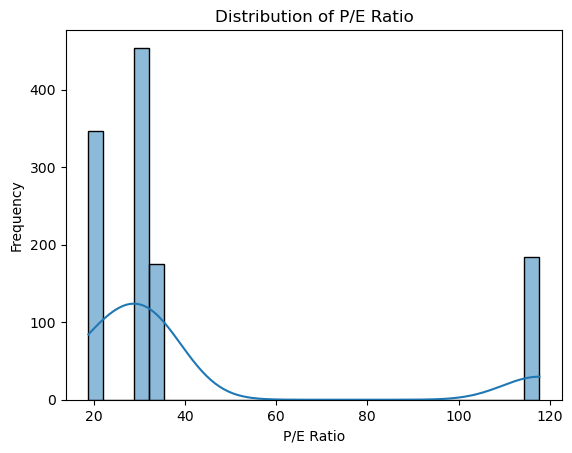

In [28]:
sns.histplot(df['P/E Ratio'], bins=30, kde=True)
plt.title('Distribution of P/E Ratio')
plt.xlabel('P/E Ratio')
plt.ylabel('Frequency')
plt.show()

### Market Cap vs. Stock Price (Scatter Plot)

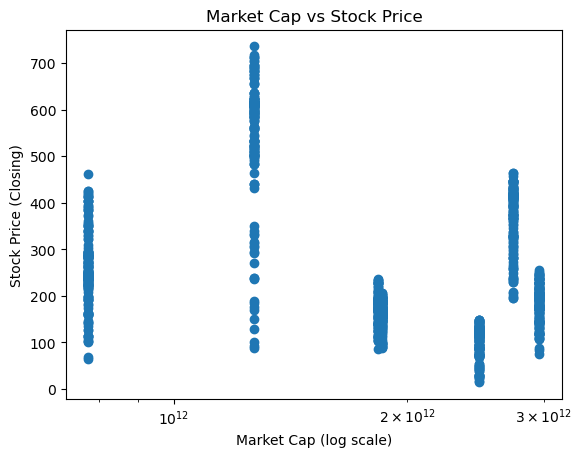

In [30]:
plt.scatter(df['Market Cap'], df['Stock Price (Closing)'])
plt.xscale('log')  # Market cap often spans large values
plt.title('Market Cap vs Stock Price')
plt.xlabel('Market Cap (log scale)')
plt.ylabel('Stock Price (Closing)')
plt.show()

### EPS vs. P/E Ratio

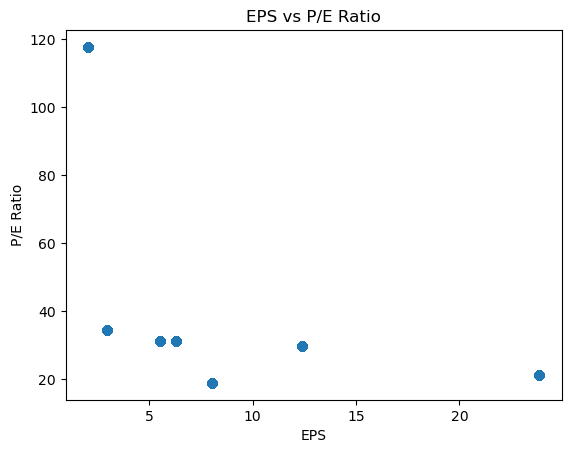

In [32]:
plt.scatter(df['EPS'], df['P/E Ratio'])
plt.title('EPS vs P/E Ratio')
plt.xlabel('EPS')
plt.ylabel('P/E Ratio')
plt.show()

### Average Sentiment by Company

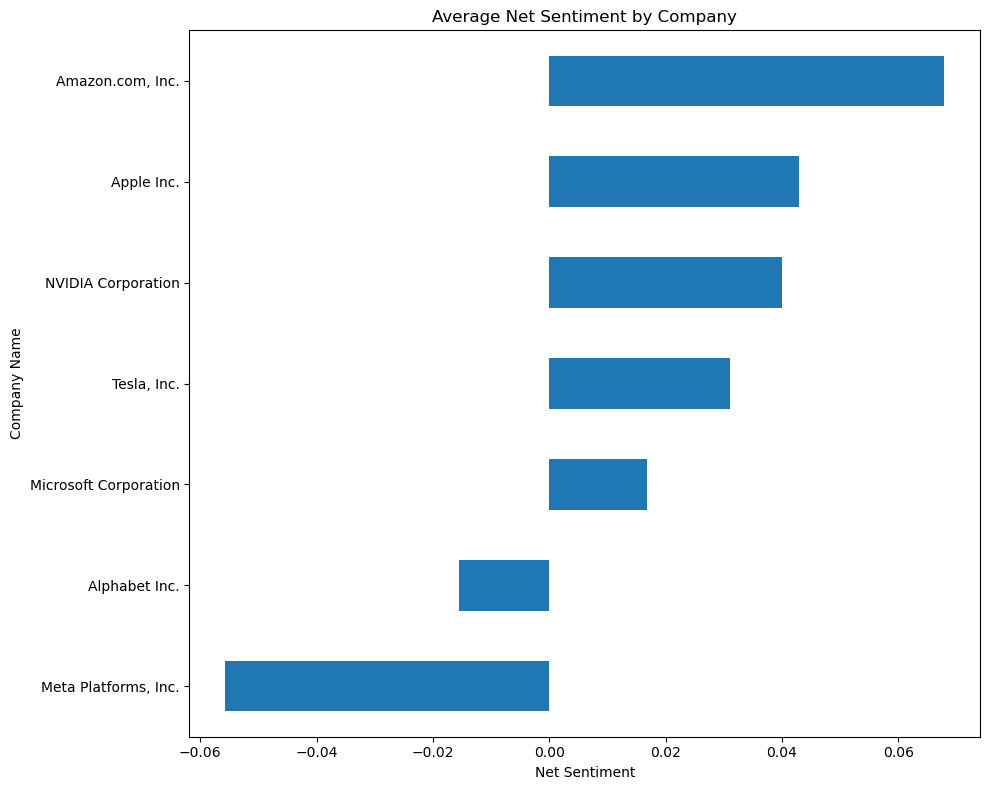

In [34]:
df['Net_Sentiment'] = df['Sentiment_Positive'] - df['Sentiment_Negative']
sentiment_by_company = df.groupby('Company Name')['Net_Sentiment'].mean().sort_values()

sentiment_by_company.plot(kind='barh', figsize=(10, 8))
plt.title('Average Net Sentiment by Company')
plt.xlabel('Net Sentiment')
plt.ylabel('Company Name')
plt.tight_layout()
plt.show()

### Correlation Heatmap

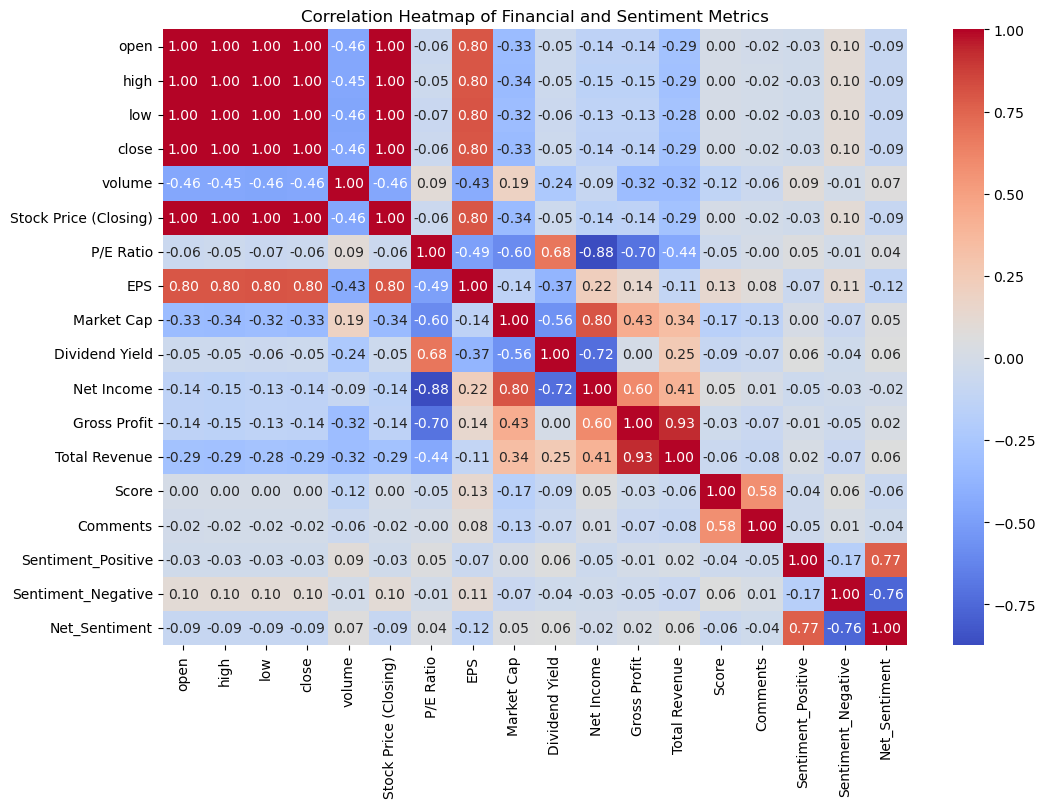

In [36]:
corr = df.select_dtypes(include='number').corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Financial and Sentiment Metrics')
plt.show()

### Stock Price Movement Over Time (Top Company)

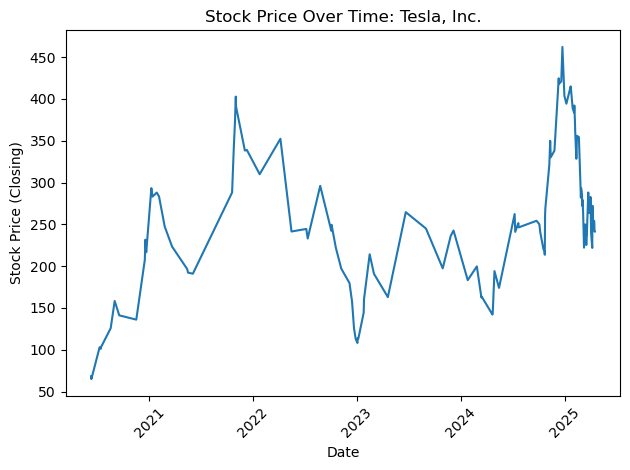

In [38]:
top_company = df['Company Name'].value_counts().idxmax()
df_top = df[df['Company Name'] == top_company].sort_values('Date')

plt.plot(pd.to_datetime(df_top['Date']), df_top['Stock Price (Closing)'])
plt.title(f'Stock Price Over Time: {top_company}')
plt.xlabel('Date')
plt.ylabel('Stock Price (Closing)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analysis

In [40]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

In [41]:
df['Net_Sentiment'] = df['Sentiment_Positive'] - df['Sentiment_Negative']
df['Engagement'] = df['Score'] + df['Comments']

In [42]:
# Filter the dataset to include only posts with high engagement (>500) and strong sentiment (absolute net sentiment > 0.1)
filtered_df = df[
    (df['Engagement'] > 500) & 
    (df['Net_Sentiment'].abs() > 0.1)
].copy()

# Set the Date column as the index to enable time-based resampling
filtered_df.set_index('Date', inplace=True)

# Resample data to weekly intervals, aggregating net sentiment by mean and taking the last stock price of the week
weekly_df = filtered_df.resample('W').agg({
    'Net_Sentiment': 'mean',
    'Stock Price (Closing)': 'last'
})

# Calculate weekly percentage change in stock price
weekly_df['Price_Change_Pct'] = weekly_df['Stock Price (Closing)'].pct_change() * 100

# Remove rows with NaN values resulting from the percentage change calculation
weekly_df.dropna(inplace=True)

# Compute correlation between weekly net sentiment and weekly stock price change
correlation = weekly_df[['Net_Sentiment', 'Price_Change_Pct']].corr().iloc[0, 1]


/var/folders/52/9ddv2mw95qd45cytzrl7jmfm0000gn/T/ipykernel_37287/3099483378.py:17: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  weekly_df['Price_Change_Pct'] = weekly_df['Stock Price (Closing)'].pct_change() * 100


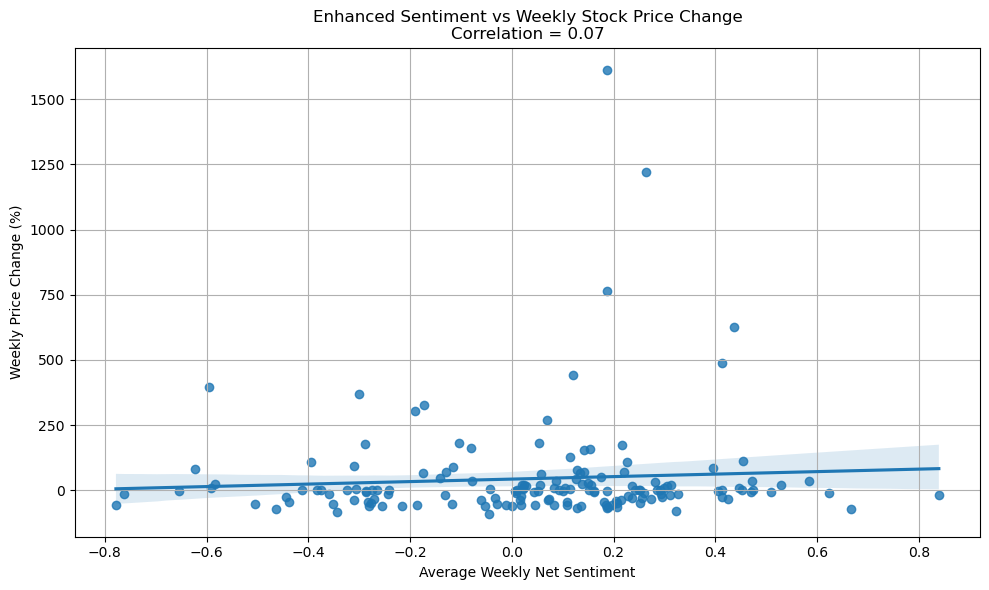

Final Correlation (Sentiment vs Weekly Price Change): 0.0715


In [43]:
plt.figure(figsize=(10, 6))
sns.regplot(data=weekly_df, x='Net_Sentiment', y='Price_Change_Pct')
plt.title(f"Enhanced Sentiment vs Weekly Stock Price Change\nCorrelation = {correlation:.2f}")
plt.xlabel("Average Weekly Net Sentiment")
plt.ylabel("Weekly Price Change (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


print(f"Final Correlation (Sentiment vs Weekly Price Change): {correlation:.4f}")

/var/folders/52/9ddv2mw95qd45cytzrl7jmfm0000gn/T/ipykernel_37287/2168876591.py:14: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  weekly_df['Price_Change_Pct'] = weekly_df['Stock Price (Closing)'].pct_change() * 100


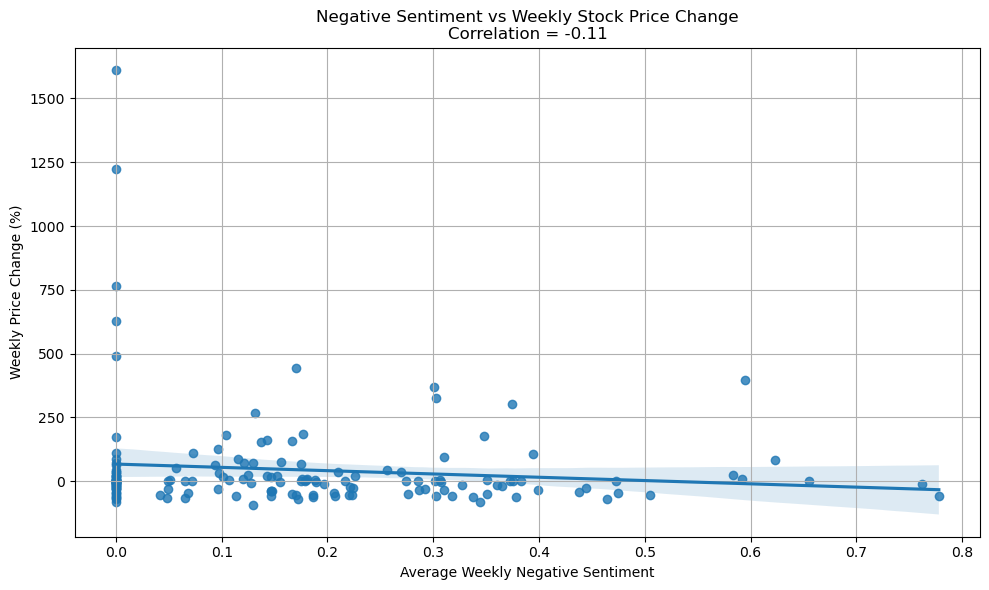

Correlation between Negative Sentiment and Stock Return: -0.1123


In [44]:
filtered_df = df[
    (df['Engagement'] > 500) & 
    (df['Net_Sentiment'].abs() > 0.1)
].copy()


filtered_df.set_index('Date', inplace=True)
weekly_df = filtered_df.resample('W').agg({
    'Sentiment_Negative': 'mean',
    'Stock Price (Closing)': 'last'
})


weekly_df['Price_Change_Pct'] = weekly_df['Stock Price (Closing)'].pct_change() * 100
weekly_df.dropna(inplace=True)


correlation = weekly_df[['Sentiment_Negative', 'Price_Change_Pct']].corr().iloc[0, 1]


plt.figure(figsize=(10, 6))
sns.regplot(data=weekly_df, x='Sentiment_Negative', y='Price_Change_Pct')
plt.title(f"Negative Sentiment vs Weekly Stock Price Change\nCorrelation = {correlation:.2f}")
plt.xlabel("Average Weekly Negative Sentiment")
plt.ylabel("Weekly Price Change (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


print(f"Correlation between Negative Sentiment and Stock Return: {correlation:.4f}")

/var/folders/52/9ddv2mw95qd45cytzrl7jmfm0000gn/T/ipykernel_37287/4147832311.py:17: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  weekly_df['Price_Change_Pct'] = weekly_df['Stock Price (Closing)'].pct_change() * 100


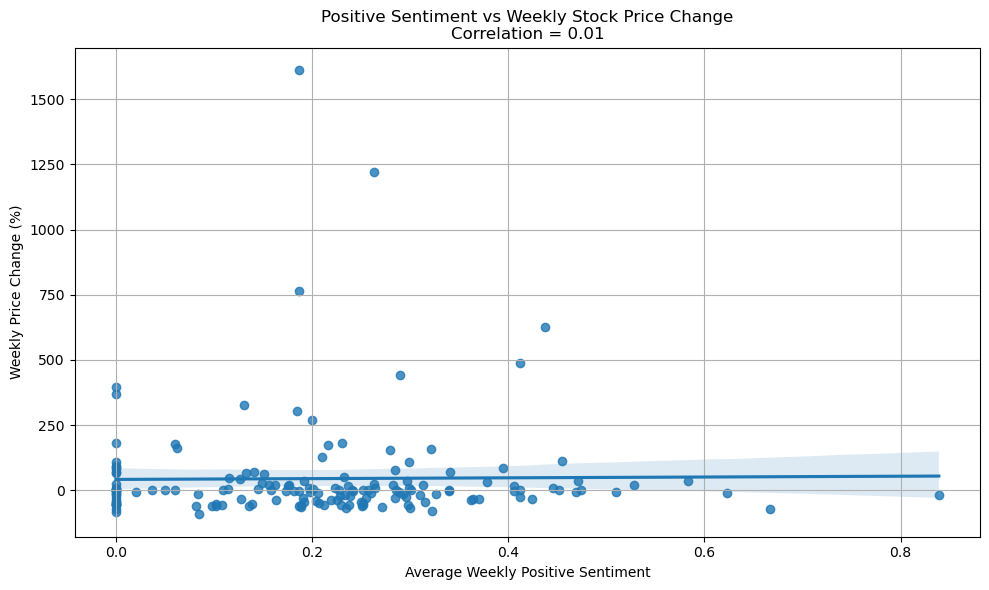

Correlation between Positive Sentiment and Stock Return: 0.0120


In [45]:
# Filter data based on engagement and absolute net sentiment
filtered_df = df[
    (df['Engagement'] > 500) & 
    (df['Net_Sentiment'].abs() > 0.1)
].copy()

# Set Date as index
filtered_df.set_index('Date', inplace=True)

# Resample weekly and compute average positive sentiment and last weekly stock price
weekly_df = filtered_df.resample('W').agg({
    'Sentiment_Positive': 'mean',
    'Stock Price (Closing)': 'last'
})

# Calculate percentage change in stock price
weekly_df['Price_Change_Pct'] = weekly_df['Stock Price (Closing)'].pct_change() * 100
weekly_df.dropna(inplace=True)

# Compute correlation
correlation = weekly_df[['Sentiment_Positive', 'Price_Change_Pct']].corr().iloc[0, 1]

# Plot regression
plt.figure(figsize=(10, 6))
sns.regplot(data=weekly_df, x='Sentiment_Positive', y='Price_Change_Pct')
plt.title(f"Positive Sentiment vs Weekly Stock Price Change\nCorrelation = {correlation:.2f}")
plt.xlabel("Average Weekly Positive Sentiment")
plt.ylabel("Weekly Price Change (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print correlation value
print(f"Correlation between Positive Sentiment and Stock Return: {correlation:.4f}")


/var/folders/52/9ddv2mw95qd45cytzrl7jmfm0000gn/T/ipykernel_37287/2499617080.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_returns_by_tier = filtered.groupby('EPS_Tier')['Total_Return_Pct'].mean()


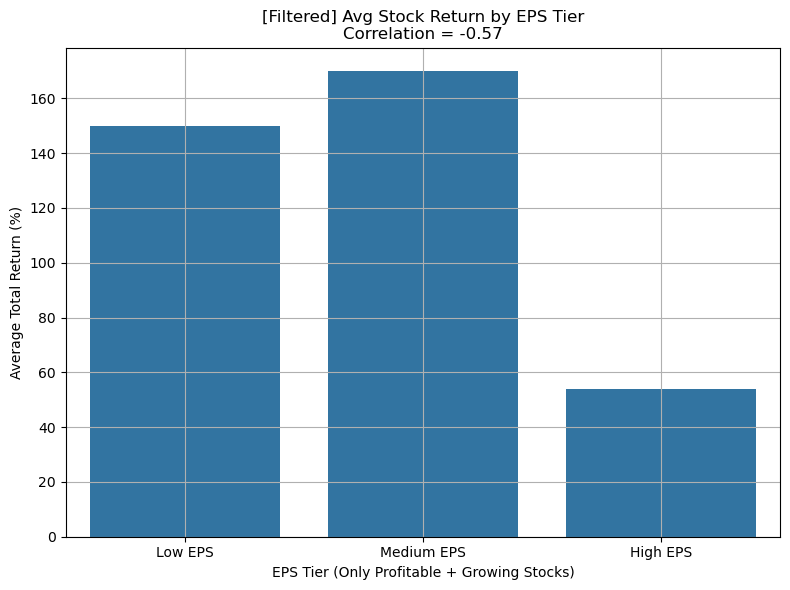

Correlation between EPS and Stock Return (Filtered): -0.5681

Average Total Return by EPS Tier:
EPS_Tier
Low EPS       149.871736
Medium EPS    169.963072
High EPS       54.004384
Name: Total_Return_Pct, dtype: float64


In [46]:
# Group by company and calculate average EPS, starting and ending stock price, average P/E ratio, and average net income
summary = df.groupby('Company Name').agg({
    'EPS': 'mean',
    'Stock Price (Closing)': ['first', 'last'],
    'P/E Ratio': 'mean',
    'Net Income': 'mean'
})

# Rename the multi-level columns for easier access
summary.columns = ['EPS_mean', 'Price_First', 'Price_Last', 'PE_mean', 'Net_Income_mean']
summary.reset_index(inplace=True)

# Calculate the total percentage return for each company over the available time period
summary['Total_Return_Pct'] = ((summary['Price_Last'] - summary['Price_First']) / summary['Price_First']) * 100

# Define 10th and 90th percentiles of EPS to filter out extreme values (outliers)
q10, q90 = summary['EPS_mean'].quantile([0.10, 0.90])

# Filter data to include only profitable, growing companies within the middle 80% EPS range
filtered = summary[
    (summary['EPS_mean'] > 0) &
    (summary['Total_Return_Pct'] > 0) &
    (summary['EPS_mean'] >= q10) &
    (summary['EPS_mean'] <= q90)
].copy()

# Create EPS tiers (Low, Medium, High) by dividing the filtered data into quantile-based bins
filtered['EPS_Tier'] = pd.qcut(filtered['EPS_mean'], q=3, labels=['Low EPS', 'Medium EPS', 'High EPS'])

# Calculate the average stock return for each EPS tier
avg_returns_by_tier = filtered.groupby('EPS_Tier')['Total_Return_Pct'].mean()

# Compute correlation between average EPS and total stock return for the filtered data
correlation = filtered[['EPS_mean', 'Total_Return_Pct']].corr().iloc[0, 1]

# Visualize the average return by EPS tier
plt.figure(figsize=(8, 6))
sns.barplot(x=avg_returns_by_tier.index, y=avg_returns_by_tier.values)
plt.title(f"[Filtered] Avg Stock Return by EPS Tier\nCorrelation = {correlation:.2f}")
plt.ylabel("Average Total Return (%)")
plt.xlabel("EPS Tier (Only Profitable + Growing Stocks)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print correlation and average return by EPS tier
print("Correlation between EPS and Stock Return (Filtered):", round(correlation, 4))
print("\nAverage Total Return by EPS Tier:")
print(avg_returns_by_tier)


In [47]:
# Group data by company to compute key aggregated metrics:
# - First and last stock prices for return calculation
# - Average P/E Ratio, Market Cap, and sentiment values
summary = df.groupby('Company Name').agg({
    'Stock Price (Closing)': ['first', 'last'],
    'P/E Ratio': 'mean',
    'Market Cap': 'mean',
    'Sentiment_Positive': 'mean',
    'Sentiment_Negative': 'mean'
})

# Rename flattened multi-level column names for easier access
summary.columns = ['Price_First', 'Price_Last', 'PE_mean', 'Market_Cap_mean', 'Sent_Pos', 'Sent_Neg']
summary.reset_index(inplace=True)

# Calculate total percentage return over the available period
summary['Total_Return_Pct'] = ((summary['Price_Last'] - summary['Price_First']) / summary['Price_First']) * 100

# Compute net sentiment by subtracting negative from positive sentiment
summary['Net_Sentiment'] = summary['Sent_Pos'] - summary['Sent_Neg']

# Filter out companies with invalid or missing key data (e.g., non-positive price or missing features)
summary_filtered = summary[
    (summary['Price_First'] > 0) &
    summary[['PE_mean', 'Market_Cap_mean', 'Net_Sentiment']].notnull().all(axis=1)
].copy()

# Prepare the independent variables (features) and add a constant for intercept in the regression
X = summary_filtered[['PE_mean', 'Market_Cap_mean', 'Net_Sentiment']]
X = sm.add_constant(X)

# Define the dependent variable (target) as total return percentage
y = summary_filtered['Total_Return_Pct']

# Fit an Ordinary Least Squares (OLS) linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results, including coefficients, R-squared, and p-values
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       Total_Return_Pct   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     2.092
Date:                Tue, 06 May 2025   Prob (F-statistic):              0.280
Time:                        17:48:41   Log-Likelihood:                -37.214
No. Observations:                   7   AIC:                             82.43
Df Residuals:                       3   BIC:                             82.21
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -126.5198    161.133     

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


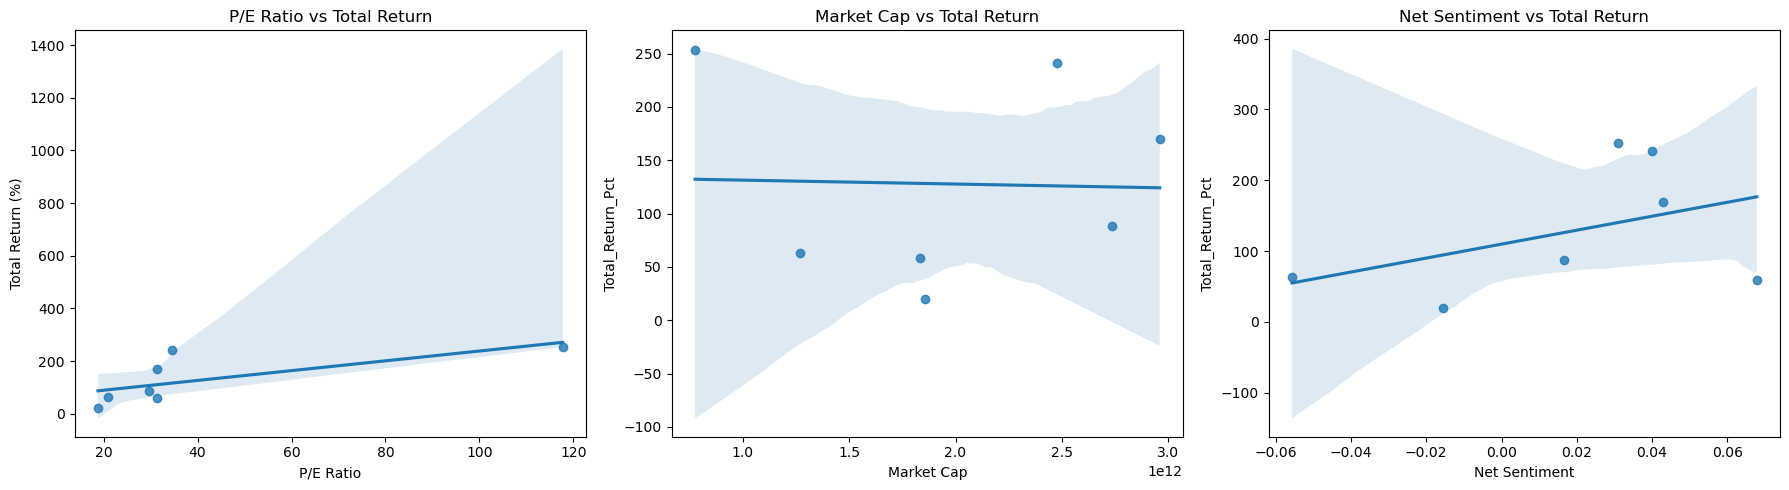

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.regplot(ax=axes[0], data=summary_filtered, x='PE_mean', y='Total_Return_Pct')
axes[0].set_title('P/E Ratio vs Total Return')
axes[0].set_xlabel('P/E Ratio')
axes[0].set_ylabel('Total Return (%)')

sns.regplot(ax=axes[1], data=summary_filtered, x='Market_Cap_mean', y='Total_Return_Pct')
axes[1].set_title('Market Cap vs Total Return')
axes[1].set_xlabel('Market Cap')

sns.regplot(ax=axes[2], data=summary_filtered, x='Net_Sentiment', y='Total_Return_Pct')
axes[2].set_title('Net Sentiment vs Total Return')
axes[2].set_xlabel('Net Sentiment')

plt.tight_layout()
plt.show()

/var/folders/52/9ddv2mw95qd45cytzrl7jmfm0000gn/T/ipykernel_37287/788224859.py:15: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  weekly['Price_Change_Pct'] = weekly['Stock Price (Closing)'].pct_change() * 100


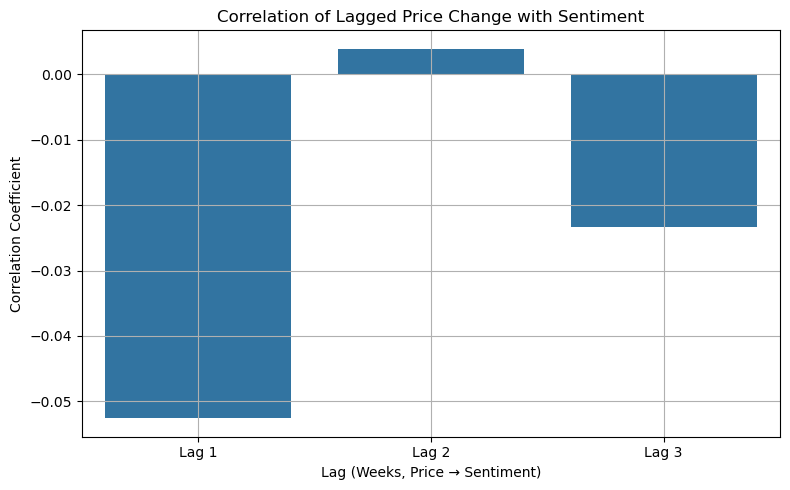

{'Lag 1': -0.05258945797786065,
 'Lag 2': 0.003921165173965097,
 'Lag 3': -0.02338132062476362}

In [49]:
# Create a new column for user engagement by summing post score and number of comments
# Filter data to include only highly engaged posts with strong sentiment signals
filtered_df = df[(df['Engagement'] > 500) & (df['Net_Sentiment'].abs() > 0.1)].copy()

# Set the Date column as index for time series resampling
filtered_df.set_index('Date', inplace=True)

# Resample data weekly, aggregating average sentiment and last known stock price per week
weekly = filtered_df.resample('W').agg({
    'Net_Sentiment': 'mean',
    'Stock Price (Closing)': 'last'
})

# Calculate weekly percentage change in stock price
weekly['Price_Change_Pct'] = weekly['Stock Price (Closing)'].pct_change() * 100

# Compute weekly change in sentiment
weekly['Sentiment_Change'] = weekly['Net_Sentiment'].diff()

# Drop rows with NaN values created by differencing and lagging
weekly.dropna(inplace=True)

# Create lagged versions of weekly price change to test reverse causality (price change → sentiment)
for lag in range(1, 4):
    weekly[f'Lag_Price_Change_{lag}'] = weekly['Price_Change_Pct'].shift(lag)

# Drop rows with NaNs introduced by shifting
rev_df = weekly.dropna()

# Calculate correlation between past price changes and current sentiment to test if price leads sentiment
reverse_correlations = {
    f"Lag {lag}": rev_df[[f'Lag_Price_Change_{lag}', 'Net_Sentiment']].corr().iloc[0, 1]
    for lag in range(1, 4)
}

# Plot the correlation values for different lags
plt.figure(figsize=(8, 5))
sns.barplot(x=list(reverse_correlations.keys()), y=list(reverse_correlations.values()))
plt.title("Correlation of Lagged Price Change with Sentiment")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Lag (Weeks, Price → Sentiment)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the correlation results for reference
reverse_correlations


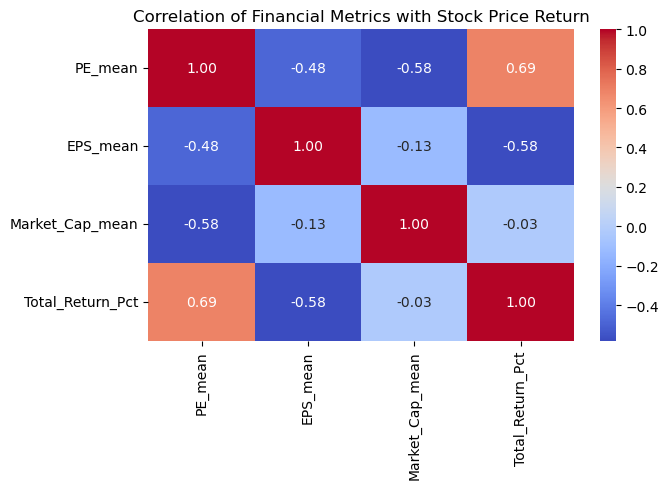

PE_mean            0.686082
Market_Cap_mean   -0.031026
EPS_mean          -0.576076
Name: Total_Return_Pct, dtype: float64

In [50]:
# Group data by company and calculate relevant financial metrics
summary_df = df.groupby('Company Name').agg({
    'P/E Ratio': 'mean',                 # Average P/E ratio for each company
    'EPS': 'mean',                       # Average EPS for each company
    'Market Cap': 'mean',                # Average market capitalization
    'Stock Price (Closing)': ['first', 'last']  # First and last closing stock prices to compute return
})

# Rename multi-level columns to simpler names
summary_df.columns = ['PE_mean', 'EPS_mean', 'Market_Cap_mean', 'Price_First', 'Price_Last']
summary_df.reset_index(inplace=True)  # Reset index to make 'Company Name' a column again

# Calculate the total stock return percentage over the time period
summary_df['Total_Return_Pct'] = ((summary_df['Price_Last'] - summary_df['Price_First']) / summary_df['Price_First']) * 100

# Select relevant features for correlation analysis
correlation_df = summary_df[['PE_mean', 'EPS_mean', 'Market_Cap_mean', 'Total_Return_Pct']]

# Compute the correlation matrix to analyze relationships
correlation_matrix = correlation_df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Financial Metrics with Stock Price Return")
plt.tight_layout()
plt.show()

# Display sorted correlations of financial metrics with return (excluding self-correlation)
correlation_matrix['Total_Return_Pct'].drop('Total_Return_Pct').sort_values(ascending=False)


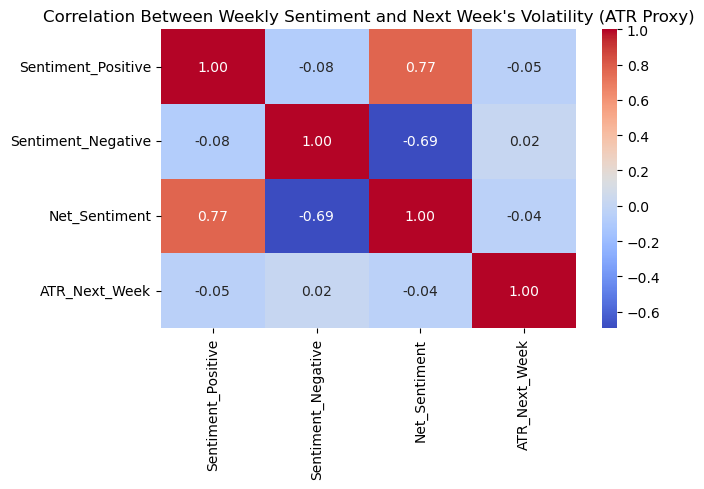

Sentiment_Negative    0.015525
Net_Sentiment        -0.044339
Sentiment_Positive   -0.047690
Name: ATR_Next_Week, dtype: float64

In [51]:
# Reset index to ensure 'Date' is a column, convert it to datetime format, and sort chronologically
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

# Compute net sentiment as the difference between positive and negative sentiment
df['Net_Sentiment'] = df['Sentiment_Positive'] - df['Sentiment_Negative']

# Calculate daily return as the percentage change in stock price
df['Daily_Return'] = df['Stock Price (Closing)'].pct_change()

# Use 5-day rolling average of absolute daily returns as a proxy for Average True Range (ATR), a volatility measure
df['ATR_Proxy'] = df['Daily_Return'].abs().rolling(window=5).mean()

# Set 'Date' as index for time-based resampling
df.set_index('Date', inplace=True)

# Aggregate weekly averages for sentiment and engagement
weekly_sentiment = df.resample('W').agg({
    'Sentiment_Positive': 'mean',
    'Sentiment_Negative': 'mean',
    'Net_Sentiment': 'mean',
    'Engagement': 'mean'
})

# Resample the volatility proxy (ATR) weekly and shift it to align with the next week's sentiment
weekly_atr = df['ATR_Proxy'].resample('W').mean()
weekly_sentiment['ATR_Next_Week'] = weekly_atr.shift(-1)

# Drop rows with missing values caused by shifting
weekly_sentiment.dropna(inplace=True)

# Compute correlation between current week's sentiment metrics and next week's volatility
atr_corr = weekly_sentiment[['Sentiment_Positive', 'Sentiment_Negative', 'Net_Sentiment', 'ATR_Next_Week']].corr()

# Visualize the correlation matrix to identify which sentiment factors best predict future volatility
plt.figure(figsize=(7, 5))
sns.heatmap(atr_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Weekly Sentiment and Next Week's Volatility (ATR Proxy)")
plt.tight_layout()
plt.show()

# Display the correlation coefficients with ATR for each sentiment type, sorted by strength
atr_corr['ATR_Next_Week'].drop('ATR_Next_Week').sort_values(ascending=False)

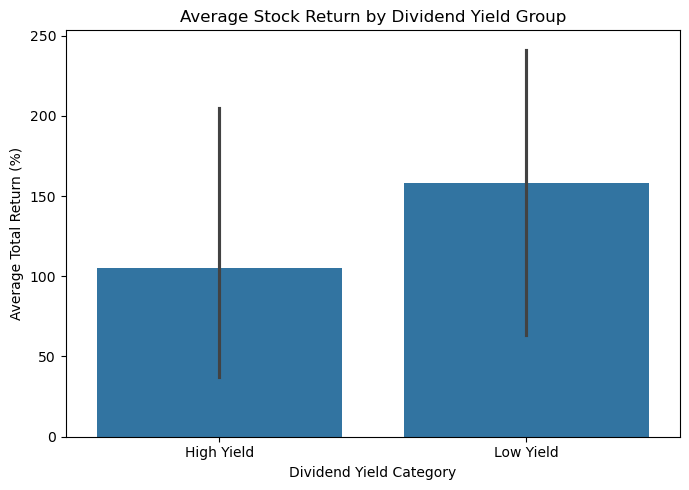

Yield_Group
High Yield    104.940203
Low Yield     158.088429
Name: Total_Return_Pct, dtype: float64

In [52]:
# Group data by company to calculate average dividend yield and first/last stock price for return calculation
summary = df.groupby('Company Name').agg({
    'Dividend Yield': 'mean',
    'Stock Price (Closing)': ['first', 'last']
})

# Flatten multi-level column names for easier access
summary.columns = ['Dividend_Yield', 'Price_First', 'Price_Last']
summary.reset_index(inplace=True)

# Calculate total return percentage for each company over the time period
summary['Total_Return_Pct'] = ((summary['Price_Last'] - summary['Price_First']) / summary['Price_First']) * 100

# Drop companies with missing dividend yield values
summary = summary.dropna(subset=['Dividend_Yield'])

# Categorize companies into 'High Yield' or 'Low Yield' based on the median dividend yield
median_yield = summary['Dividend_Yield'].median()
summary['Yield_Group'] = summary['Dividend_Yield'].apply(lambda x: 'High Yield' if x >= median_yield else 'Low Yield')

# Calculate average total return for each dividend yield group
group_avg_return = summary.groupby('Yield_Group')['Total_Return_Pct'].mean()

# Plot average stock return by dividend yield group
plt.figure(figsize=(7, 5))
sns.barplot(data=summary, x='Yield_Group', y='Total_Return_Pct')
plt.title("Average Stock Return by Dividend Yield Group")
plt.ylabel("Average Total Return (%)")
plt.xlabel("Dividend Yield Category")
plt.tight_layout()
plt.show()

# Display the average return values for each group
group_avg_return

# Stock Price

# LSTM

Epoch 1/20


2025-05-06 17:48:41.608327: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-06 17:48:41.608352: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-06 17:48:41.608355: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-05-06 17:48:41.608366: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-06 17:48:41.608373: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, 

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0856
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.6414e-04
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.0497e-04
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.2854e-04
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.4556e-04
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.3442e-04
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.0294e-04
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6295e-04
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1749e-04
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3400e-04
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9922e-04
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.4094e-04
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

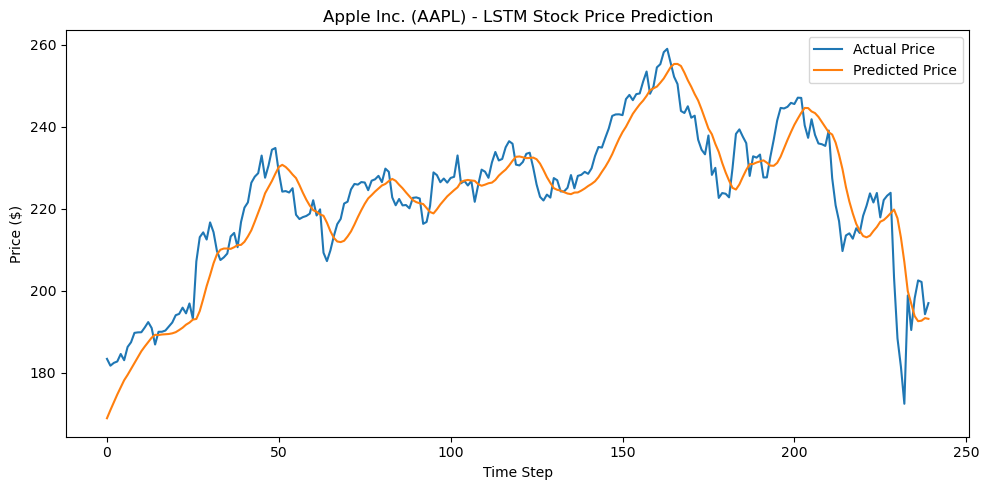

In [55]:
df = pd.read_csv("combined_stock_data_raw.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df.sort_values("datetime", inplace=True)
df.set_index('datetime', inplace=True)
df = df[df['Ticker'] == 'AAPL'].copy()

# Use only the 'close' price for prediction
df['close'] = df['close'].astype(float)
closing_prices = df[['close']].values

# Normalize data
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(closing_prices)

# Create sequences for LSTM
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled_prices, window_size)

# Split into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title("Apple Inc. (AAPL) - LSTM Stock Price Prediction")
plt.xlabel("Time Step")
plt.ylabel("Price ($)")
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
r2 = r2_score(actual_prices, predicted_prices)

metrics = {
    'RMSE': rmse,
    'MSE': mse,
    'R2 Score': r2
}

print(metrics)

{'RMSE': 7.44847518844633, 'MSE': 55.47978263290059, 'R2 Score': 0.8163938098106235}


# GRU

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1045
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0014
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.4533e-04
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.7147e-04
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3769e-04
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4478e-04
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8921e-04
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7875e-04
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8252e-04
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.4136e-04
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5454e-04
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6333e-04
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - lo

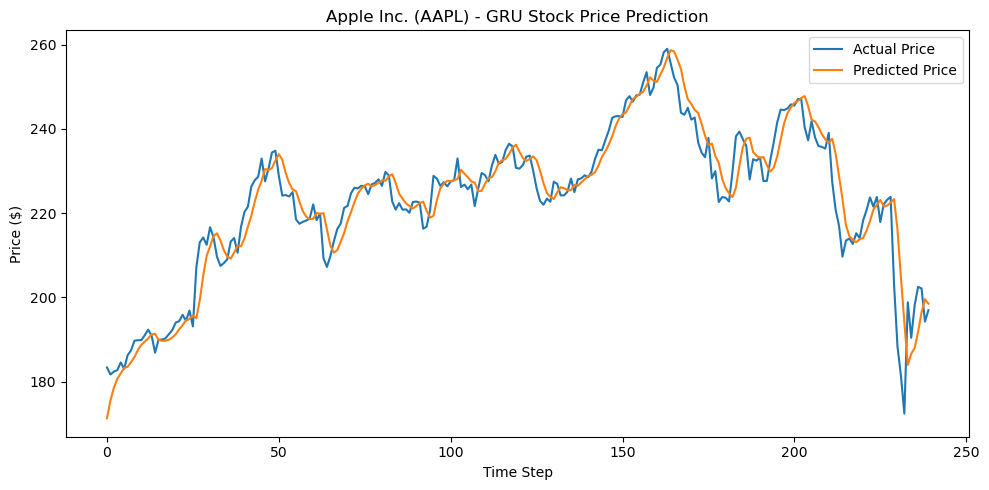

In [58]:
model = Sequential([
    GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test)

plt.figure(figsize=(10, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title("Apple Inc. (AAPL) - GRU Stock Price Prediction")
plt.xlabel("Time Step")
plt.ylabel("Price ($)")
plt.legend()
plt.tight_layout()
plt.show()

In [59]:
mse1 = mean_squared_error(actual_prices, predicted_prices)
rmse1 = np.sqrt(mse1)
r21 = r2_score(actual_prices, predicted_prices)

metrics = {
    'RMSE': rmse1,
    'MSE': mse1,
    'R2 Score': r21
}

print(metrics)

{'RMSE': 5.492636013386292, 'MSE': 30.16905037554806, 'R2 Score': 0.9001577847242521}


# CNN

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0432
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0037
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010    
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.4023e-04
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8756e-04
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0137e-04
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7510e-04
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9425e-04
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0982e-04
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6978e-0

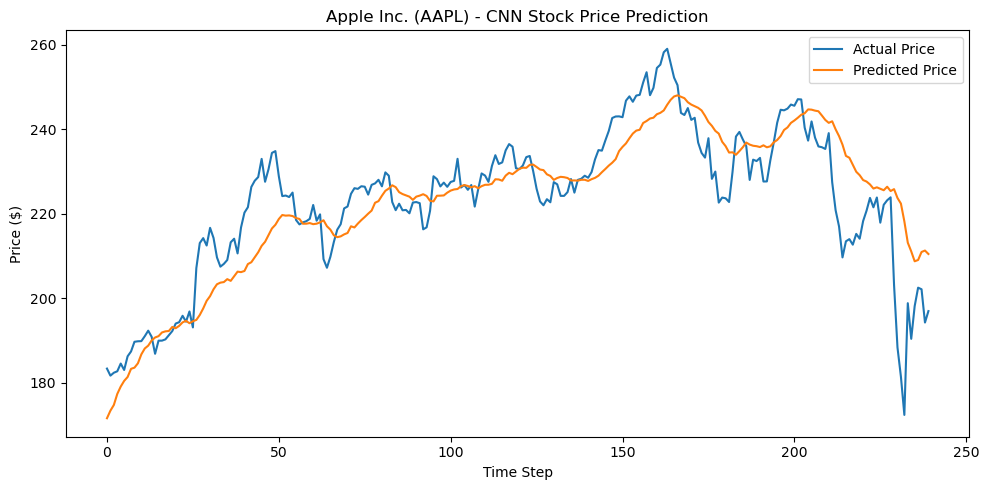

In [61]:
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    Flatten(),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test)

plt.figure(figsize=(10, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title("Apple Inc. (AAPL) - CNN Stock Price Prediction")
plt.xlabel("Time Step")
plt.ylabel("Price ($)")
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
mse2 = mean_squared_error(actual_prices, predicted_prices)
rmse2 = np.sqrt(mse2)
r22 = r2_score(actual_prices, predicted_prices)

metrics = {
    'RMSE': rmse2,
    'MSE': mse2,
    'R2 Score': r22
}

print(metrics)

{'RMSE': 9.442237732095284, 'MSE': 89.15585338940392, 'R2 Score': 0.7049453729437722}


# Xgboost

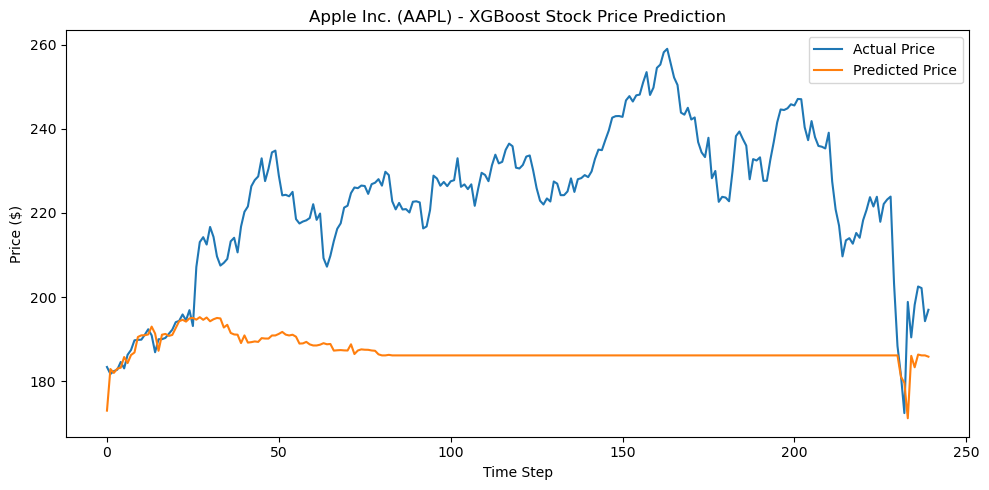

In [64]:
df['close'] = df['close'].astype(float)
closing_prices = df[['close']].values
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(closing_prices)

def create_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i].flatten())
        y.append(data[i])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled_prices, window_size)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
model.fit(X_train, y_train)

predicted = model.predict(X_test).reshape(-1, 1)
predicted_prices = scaler.inverse_transform(predicted)
actual_prices = scaler.inverse_transform(y_test)

plt.figure(figsize=(10, 5))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title("Apple Inc. (AAPL) - XGBoost Stock Price Prediction")
plt.xlabel("Time Step")
plt.ylabel("Price ($)")
plt.legend()
plt.tight_layout()
plt.show()

In [65]:
mse3 = mean_squared_error(actual_prices, predicted_prices)
rmse3 = np.sqrt(mse3)
r23 = r2_score(actual_prices, predicted_prices)

metrics = {
    'RMSE': rmse3,
    'MSE': mse3,
    'R2 Score': r23
}

print(metrics)

{'RMSE': 40.1381436014423, 'MSE': 1611.0705717700037, 'R2 Score': -4.33171753332527}


# Comparison

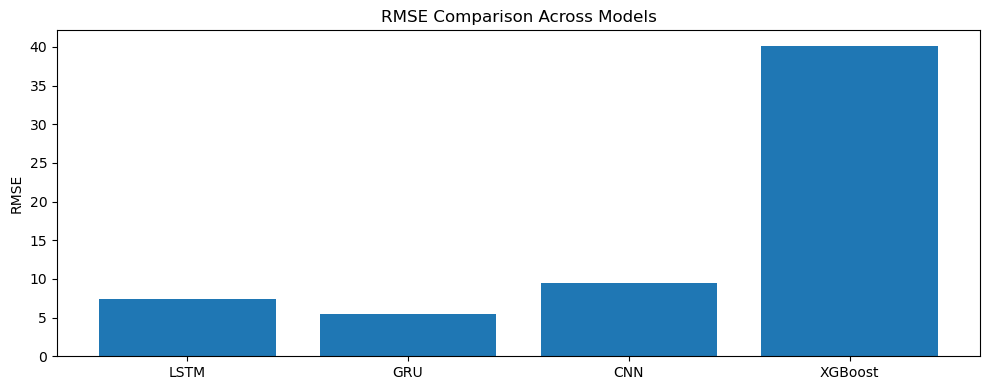

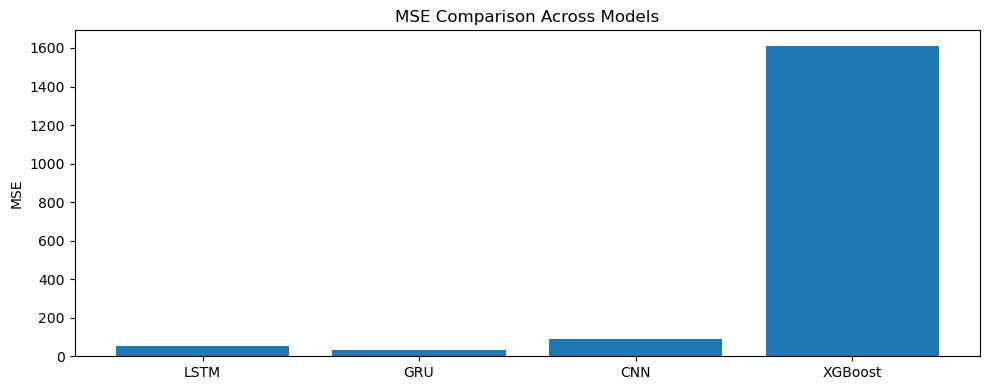

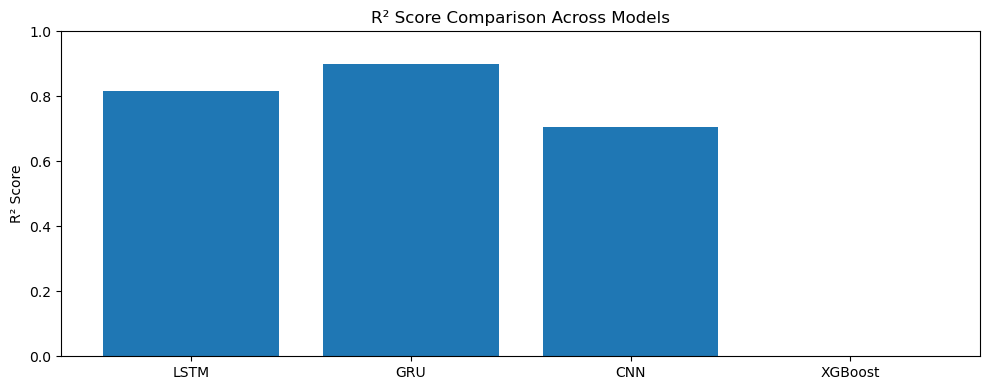

In [67]:
models = ['LSTM', 'GRU', 'CNN', 'XGBoost']
rmse_values = [rmse, rmse1, rmse2, rmse3]
mse_values = [mse, mse1, mse2, mse3]
r2_values = [r2, r21, r22, r23]

# Plot RMSE Comparison
plt.figure(figsize=(10, 4))
plt.bar(models, rmse_values)
plt.title('RMSE Comparison Across Models')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

# Plot MSE Comparison
plt.figure(figsize=(10, 4))
plt.bar(models, mse_values)
plt.title('MSE Comparison Across Models')
plt.ylabel('MSE')
plt.tight_layout()
plt.show()

# Plot R2 Score Comparison
plt.figure(figsize=(10, 4))
plt.bar(models, r2_values)
plt.title('R² Score Comparison Across Models')
plt.ylabel('R² Score')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Sentiment Analysis

# Vectorize text using TF-IDF

In [70]:
df = pd.read_csv('reddit_stockmarket_cleaned.csv')
texts = df['Processed_Title'].astype(str)
def label_sentiment(text):
    score = vader.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['Sentiment_Label'] = texts.apply(label_sentiment)
df_binary = df[df['Sentiment_Label'] != 'neutral'].copy()
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df_binary['Processed_Title'])
y = df_binary['Sentiment_Label']

# Splitting

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Naive Bayes

In [74]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

In [75]:
accuracy= report['accuracy'],
precision=report['weighted avg']['precision'],
recall=report['weighted avg']['recall'],
f1=report['weighted avg']['f1-score']

              precision    recall  f1-score   support

    negative       0.81      0.70      0.75       276
    positive       0.82      0.89      0.86       424

    accuracy                           0.82       700
   macro avg       0.82      0.80      0.80       700
weighted avg       0.82      0.82      0.81       700



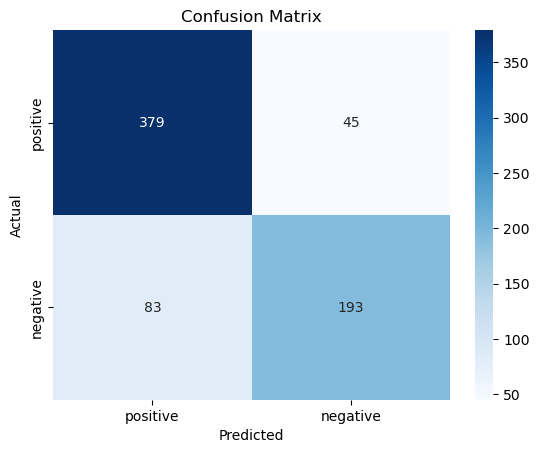

In [76]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=['positive', 'negative'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Logistic Regression

In [78]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

In [79]:
accuracy1= report['accuracy'],
precision1=report['weighted avg']['precision'],
recall1=report['weighted avg']['recall'],
f11=report['weighted avg']['f1-score']

              precision    recall  f1-score   support

    negative       0.85      0.62      0.72       276
    positive       0.79      0.93      0.85       424

    accuracy                           0.81       700
   macro avg       0.82      0.78      0.79       700
weighted avg       0.81      0.81      0.80       700



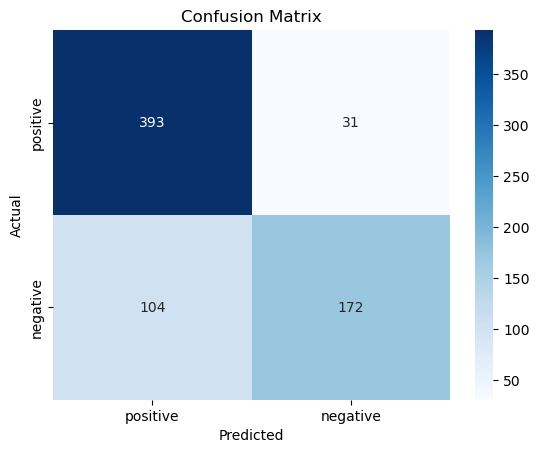

In [80]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=['positive', 'negative'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# SVM

In [82]:
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

In [83]:
accuracy2= report['accuracy'],
precision2=report['weighted avg']['precision'],
recall2=report['weighted avg']['recall'],
f12=report['weighted avg']['f1-score']

              precision    recall  f1-score   support

    negative       0.79      0.75      0.77       276
    positive       0.84      0.87      0.86       424

    accuracy                           0.82       700
   macro avg       0.82      0.81      0.81       700
weighted avg       0.82      0.82      0.82       700



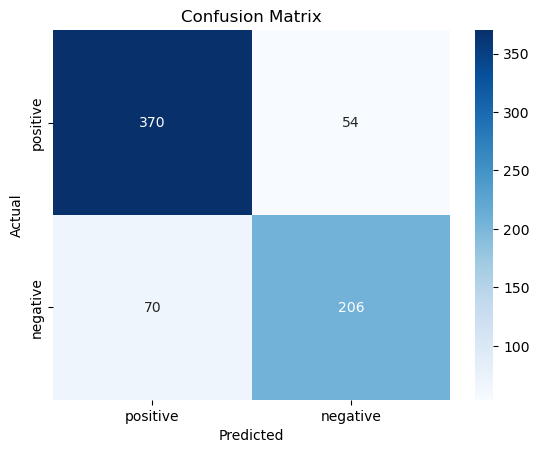

In [84]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=['positive', 'negative'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'negative'], yticklabels=['positive', 'negative'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Comparison

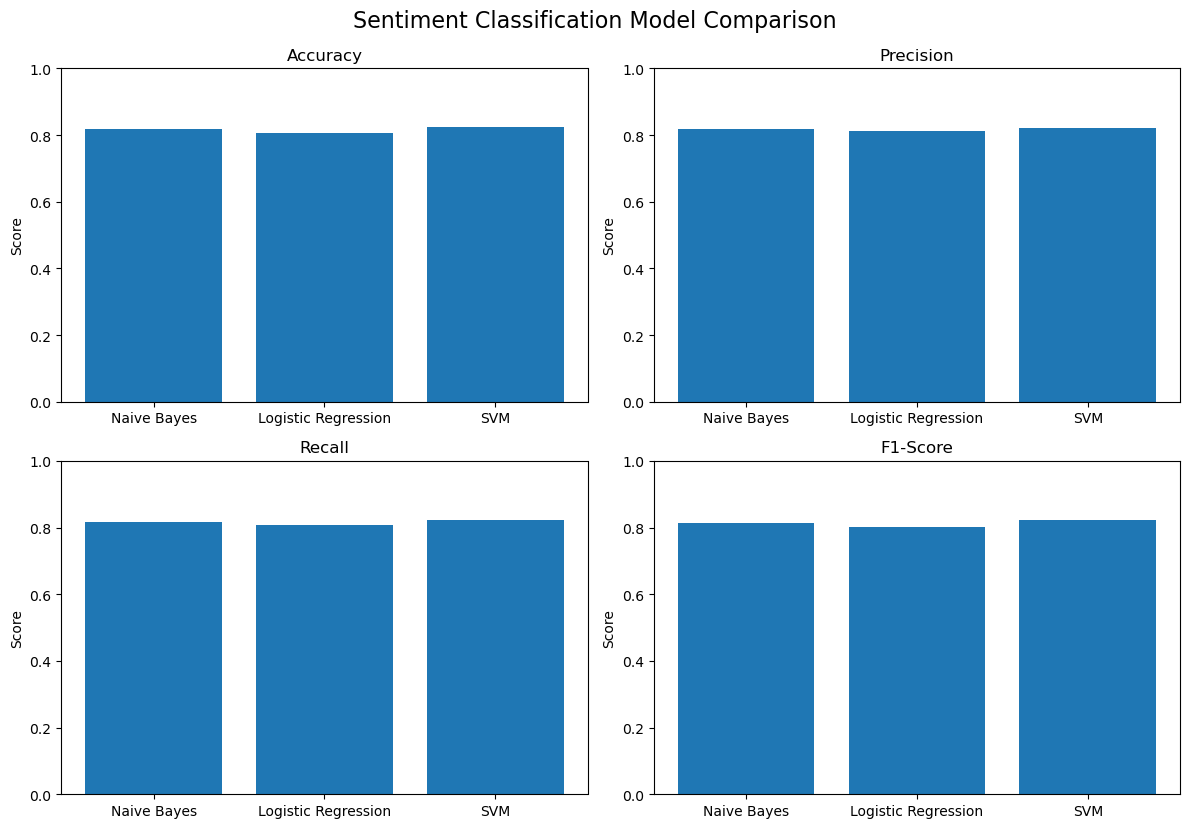

In [86]:
def extract_scalar(x):
    return x[0] if isinstance(x, tuple) else x

accuracy = extract_scalar(accuracy)
accuracy1 = extract_scalar(accuracy1)
accuracy2 = extract_scalar(accuracy2)

precision = extract_scalar(precision)
precision1 = extract_scalar(precision1)
precision2 = extract_scalar(precision2)

recall = extract_scalar(recall)
recall1 = extract_scalar(recall1)
recall2 = extract_scalar(recall2)

f1 = extract_scalar(f1)
f11 = extract_scalar(f11)
f12 = extract_scalar(f12)


models = ['Naive Bayes', 'Logistic Regression', 'SVM']

accuracy_scores = [accuracy, accuracy1, accuracy2]
precision_scores = [precision, precision1, precision2]
recall_scores = [recall, recall1, recall2]
f1_scores = [f1, f11, f12]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
metrics = [accuracy_scores, precision_scores, recall_scores, f1_scores]
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
axes = axes.ravel()

for i in range(4):
    axes[i].bar(models, metrics[i])
    axes[i].set_title(titles[i])
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel("Score")

plt.tight_layout()
plt.suptitle("Sentiment Classification Model Comparison", fontsize=16, y=1.03)
plt.show()

# User Interface

In [88]:
!pip install flask==3.0.3 pandas==2.2.2 tensorflow==2.17.0 scikit-learn==1.5.1 vaderSentiment==3.3.2 gunicorn==21.2.0 yfinance==0.2.54 matplotlib==3.9.2 numpy==1.26.4 requests==2.32.3

In [89]:
#importing libraries
from flask import Flask, render_template, request
import pandas as pd
import numpy as np
import requests
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
import time
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


#***************** FLASK *****************************
app = Flask(__name__)

#To control caching so as to save and retrieve plot figs on client side
@app.after_request
def add_header(response):
    response.headers['Pragma'] = 'no-cache'
    response.headers['Cache-Control'] = 'no-cache, no-store, must-revalidate'
    response.headers['Expires'] = '0'
    return response


@app.route('/index')
def index():
   return render_template('index.html')

@app.route('/')
@app.route('/home')
def home():
	return render_template('home.html')


def get_historical(symbol):
    apikey = '9f2a3f356de7477482431de27a7ab59c'
    end_date = datetime.today()
    start_date = end_date - timedelta(days=3650)
    url = f"https://api.twelvedata.com/time_series?symbol={symbol}&interval=1day&start_date={start_date.strftime('%Y-%m-%d')}&end_date={end_date.strftime('%Y-%m-%d')}&apikey={apikey}"

    response = requests.get(url)
    response.raise_for_status()
    data = response.json()

    if 'values' in data:
        df = pd.DataFrame(data['values'])
        df['datetime'] = pd.to_datetime(df['datetime'])
        df = df.rename(columns={
            'datetime': 'Date',
            'open': 'Open',
            'high': 'High',
            'low': 'Low',
            'close': 'Close',
            'volume': 'Volume'
        })
        df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
        df = df.sort_values('Date').reset_index(drop=True)
        df.to_csv(f"{symbol}.csv", index=False)
        return df
    else:
        return None

def fetch_reddit_data(stock_ticker, limit=1000):
    posts_data = []
    after = None
    headers = {
        "User-Agent": "Mozilla/5.0"
    }
    subreddit = 'StockMarket'
    five_years_ago = datetime.now() - timedelta(days=5*365)

    while len(posts_data) < limit:
        params = {
            'limit': 100,
            'after': after,
            'q': stock_ticker
        }

        try:
            response = requests.get(f"https://www.reddit.com/r/{subreddit}/search.json", headers=headers, params=params)
            if response.status_code == 200:
                data = response.json()
                for post in data['data']['children']:
                    try:
                        title = post['data']['title']
                        post_url = "https://www.reddit.com" + post['data']['permalink']
                        score = post['data']['score']
                        comments = post['data']['num_comments']
                        date = post['data']['created_utc']
                        post_date = pd.to_datetime(date, unit='s')

                        if post_date < five_years_ago or post_date.weekday() >= 5:
                            continue

                        posts_data.append(title)

                        if len(posts_data) >= limit:
                            break
                    except:
                        continue

                after = data['data'].get('after', None)
                if not after:
                    break
                time.sleep(10)
            else:
                break
        except:
            time.sleep(10)
            continue

    return posts_data

def analyze_sentiment(titles):
    analyzer = SentimentIntensityAnalyzer()
    total_sentiment = 0
    for title in titles:
        sentiment_score = analyzer.polarity_scores(title)['compound']
        total_sentiment += sentiment_score
    avg_sentiment = total_sentiment / len(titles) if titles else 0
    return round(avg_sentiment, 4)

def GRU_ALGO(df):
    dataset_train = df.iloc[0:int(0.8*len(df)), :]
    dataset_test = df.iloc[int(0.8*len(df)):, :]
    training_set = df.iloc[:, 4:5].values

    sc = MinMaxScaler(feature_range=(0, 1))
    training_set_scaled = sc.fit_transform(training_set)

    X_train, y_train = [], []
    for i in range(30, len(training_set_scaled)):
        X_train.append(training_set_scaled[i-30:i, 0])
        y_train.append(training_set_scaled[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_forecast = np.append(X_train[-1, 1:], y_train[-1])
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_forecast = np.reshape(X_forecast, (1, X_forecast.shape[0], 1))

    model = Sequential([
        GRU(64, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    real_stock_price = dataset_test.iloc[:, 4:5].values
    dataset_total = pd.concat((dataset_train['Close'], dataset_test['Close']), axis=0)
    testing_set = dataset_total[len(dataset_total) - len(dataset_test) - 30:].values.reshape(-1, 1)
    testing_set = sc.transform(testing_set)

    X_test = []
    for i in range(30, len(testing_set)):
        X_test.append(testing_set[i-30:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)

    error_gru = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
    forecasted_stock_price = model.predict(X_forecast)
    forecasted_stock_price = sc.inverse_transform(forecasted_stock_price)
    gru_pred = forecasted_stock_price[0, 0]

    fig = plt.figure(figsize=(7.2, 4.8), dpi=65)
    plt.plot(real_stock_price.flatten(), label='Actual Price')
    plt.plot(predicted_stock_price.flatten(), label='Predicted Price')
    plt.legend(loc=4)
    plt.tight_layout()
    plt.savefig('static/GRU.png')
    plt.close(fig)


    return gru_pred, error_gru

@app.route('/predict', methods=['POST'])
def predict():
    nm = request.form['nm']
    quote = nm.upper()
    try:
        get_historical(quote)
    except:
        return render_template('index.html', not_found=True)

    df = pd.read_csv(f"{quote}.csv")
    df = df.dropna()
    today_stock = df.iloc[-1:]
    gru_pred, error_gru = GRU_ALGO(df)
    reddit_titles = fetch_reddit_data(quote, limit=200)
    sentiment_score = analyze_sentiment(reddit_titles)
    if sentiment_score >= 0.05:
        recommendation = "BUY"
    elif sentiment_score <= -0.05:
        recommendation = "SELL"
    else:
        recommendation = "HOLD"

    return render_template("results.html",
        quote=quote,
        gru_pred=round(gru_pred, 2),
        open_s=today_stock['Open'].to_string(index=False),
        close_s=today_stock['Close'].to_string(index=False),
        high_s=today_stock['High'].to_string(index=False),
        low_s=today_stock['Low'].to_string(index=False),
        vol=today_stock['Volume'].to_string(index=False),
        error_gru=round(error_gru, 2),
        sentiment_score=sentiment_score,
        recommendation=recommendation
    )

if __name__ == '__main__':
    app.run(port=5000)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
